## Dataset I. target_dataset
<br>
<img src="./images/target_dataset.png"/>

Explanation for the columns:
1. `person` (int)
    - Id for person: already encoded to int number
2. `offer_id` (object of str)
    - Id for offer: already encoded to int number
    - **Values**: from '0' to '9'
3. `time_received` (float)
    - time of reveiving the offer
    - **Values**: `NaN` represent not received
4. `time_viewed` (float) 
    - time of viewing the offer
    - **Values**: `NaN` represent not viewed
5. `time_transaction` (object of str)
    - time of the transactions within an transaction unit(within one unique offer_id of one person, there may be more transaction units)
    - **Values**: there maybe more than one transactions within a transaction unit, so use `str`(obeject) to represent
        - `''` means there is no transaction
        - `',3.8,5.9'` means there is two transactions, one is at time 3.8, another in at time 5.9
6. `time_completed` (float)
    - time of complete the offer
    - **Values**: `NaN` represent not completed
7. `amount_with_offer` (float)
    - amount of transaction(s) within this transaction unit
    - **Values**: '0.0' represent no transaction
8. `label_effective_offer` (int) **!!!Attention: has no infomation about 'offer viewed'**
    - the label to mark the completion level of offer
    - **Values**:
        - `1`: 
            - for informational offer there is at least one transaction within duration; 
            - for other offer there should be 'offer completed'
        - `0`: 
            - for informational offer there is no valid transaction within the duration but 'offer received'; 
            - for other offers there is no 'offer completed', but within duration there is some amount, although the amount of transactions may not fulfil requirements
        - `-1`: the init label, when there is no 'offer received', the label keeps '-1'<br>(after wrangled to '-2', there is no more label of '-1')
        - `-2`: Special, some interesting discovering after the data was wrangled
            - represent some people: they only have transactions within all the experimantal time , no offer was sent to them(this situation appears because some person haven't received any offer)

## Dataset II. transcript_offer(updated)

```python
### Code
# Just show the updated part:
normal_offer_id = target_dataset.offer_id.unique().tolist()   # ['0','1','2','3','4','5','6','7','8','9']
# show transaction, the offer_id is not normal(some has been updated by wrangling)
transcript_offer[~transcript_offer.offer_id.isin(normal_offer_id)].tail(20)
```
<img src="./images/transcript_offer.png"/>
Some values in column 'offer_id' are updated.<br>
In figure, the value '6,5' represent:<br>
　　this transaction is valid for two offer_ids: one is '6', another is '5'.

# <a class="anchor" id="Start">Table of Contents</a>

I. [Feature Engineer](#1)<br>
II.[Segement of the Person](#2)<br>
III.[Classes of responsiveness to the offers](#3)<br>
   1. [Divide the response into 4 groups](#3.1)<br>
   2. [CHECK the dividing method for the 4 groups of response to offer](#3.2)<br>
   3. [Heuristic exploration in 4 aspects](#3.3)<br>
        3.1 [Offer Distributions: none_offer VS. others](#3.3.1)<br>
            i. Visualization
            ii. Conclusion
        3.2 [Interest Distributions: no_care VS. (tried & effective_offer)](#3.3.2)<br>
            i. Visualization
            ii. Conclusion
        3.3 [Difficulty Distributions: tried VS. effective_offer](#3.3.3)<br>
            i. Visualization
            ii. Conclusion
        3.4 [Index NIR: Is the offer significant popular?](#3.3.4)<br>
            i. Visualization
            ii. Conclusion
    
IV.[Explore the wrangled Data](#4)(preliminary)<br>
[References](#References)

### Imports & Load in data

In [1]:
import pandas as pd
import numpy as np
import math
import json

from time import time
from datetime import date
from collections import defaultdict

import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

# detail for offers
portfolio_raw = pd.read_csv('./data_generated/cleaned_portfolio.csv', dtype={'offer_id': str})
del portfolio_raw['Unnamed: 0']

# detail for person
profile_raw = pd.read_csv('./data_generated/cleaned_profile.csv')
del profile_raw['Unnamed: 0']

# wrangled transcript with updated information of offer
transcript_offer_raw = pd.read_csv('./data_generated/wrangled_transcript_offer.csv', dtype={'person': int})
# recover to original dataset: index is the same
transcript_offer_raw.index = transcript_offer_raw.iloc[:, 0].values
del transcript_offer_raw['Unnamed: 0']

# wrangled ideal target_dataset
target_dataset_raw = pd.read_csv('./data_generated/modified_wrangled_target_dataset.csv', dtype={'person': int, 'offer_id': str})
# recover to original dataset: index is the same
target_dataset_raw.index = target_dataset_raw.iloc[:, 0].values
del target_dataset_raw['Unnamed: 0']

In [2]:
portfolio = portfolio_raw.copy()
profile = profile_raw.copy()
transcript_offer = transcript_offer_raw.copy()
target_dataset = target_dataset_raw.copy()

## <a class="anchor" id="1">[I. Feature Engineer](#Start)</a>

### 1. Potential feature 
- Transform column 'became_member_on' in `profile`

In [3]:
# rename column for merging
profile.rename(columns={'id': 'person'}, inplace=True)

In [4]:
def transform_date(input_date):
    '''Transform date(int) to normal date(date form)
    '''
    year = int(str(input_date)[:4])
    month = int(str(input_date)[4:6])
    day = int(str(input_date)[-2:])
    actual_date = date(year, month, day)
    
    return actual_date

In [5]:
# create funciton to transform the register date to member_days 
latest_date = profile['became_member_on'].max()  #20180726

def transform_member_days(input_date, latest_date):
    '''Transform the register date to member_days.
    
    INPUT:
        - date (int): the register date, e.g. 20180726
        - latest_date (int): the latest register date, 20180726
    
    OUTPUT:
        - member_days (int): the days apart from the latest new year, 2019.01.01
    '''
    # suppose we use the begin of the next year as the experimental date, here is 2019.01.01
    latest_year = int(str(latest_date)[:4]) + 1  # 2019: used to calculate
    refer_date = date(latest_year, 1, 1)
    
    year = int(str(input_date)[:4])
    month = int(str(input_date)[4:6])
    day = int(str(input_date)[-2:])
    actual_date = date(year, month, day)
    
    # get the date difference to the refer_date
    member_days = (refer_date - actual_date).days

    return member_days


profile['member_days'] = profile['became_member_on'].apply(transform_member_days, args=(latest_date,))
profile['register_date'] = profile['became_member_on'].apply(transform_date)

profile

,gender,age,person,became_member_on,income,member_days,register_date
0,F,55,1,20170715,112000.0,535,2017-07-15
1,F,75,3,20170509,100000.0,602,2017-05-09
2,M,68,5,20180426,70000.0,250,2018-04-26
3,M,65,8,20180209,53000.0,326,2018-02-09
4,M,58,12,20171111,51000.0,416,2017-11-11
...,...,...,...,...,...,...,...
14820,F,45,16995,20180604,54000.0,211,2018-06-04
14821,M,61,16996,20180713,72000.0,172,2018-07-13
14822,M,49,16997,20170126,73000.0,705,2017-01-26
14823,F,83,16998,20160307,50000.0,1030,2016-03-07


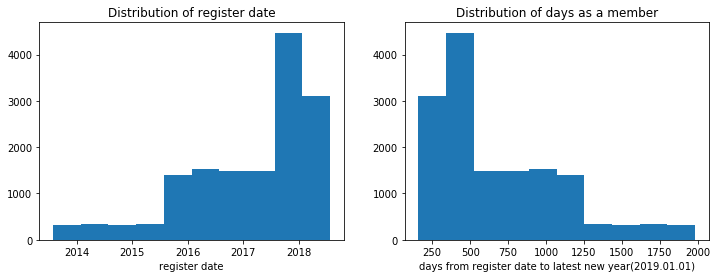

In [6]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.hist(data=profile, x='register_date')
plt.title('Distribution of register date')
plt.xlabel('register date')

plt.subplot(1,2,2)
plt.hist(data=profile, x='member_days')
plt.title('Distribution of days as a member')
plt.xlabel('days from register date to latest new year(2019.01.01)')

plt.show()

# after visualization delete useless columns
profile.drop(columns=['became_member_on', 'register_date'], inplace=True )

In [7]:
profile

,gender,age,person,income,member_days
0,F,55,1,112000.0,535
1,F,75,3,100000.0,602
2,M,68,5,70000.0,250
3,M,65,8,53000.0,326
4,M,58,12,51000.0,416
...,...,...,...,...,...
14820,F,45,16995,54000.0,211
14821,M,61,16996,72000.0,172
14822,M,49,16997,73000.0,705
14823,F,83,16998,50000.0,1030


### 2. Merge the dataset to combine all the potential features 

In [8]:
target_dataset = target_dataset.merge(portfolio, how='left', on='offer_id').merge(profile, how='left', on='person')

## <a class="anchor" id="2">[II. Segement of the Person](#Start)</a>
Since there are too many individuals, it's better to set some customer groups to excavate more common pattern in each group.<br>
According to [References[1]](https://github.com/syuenloh/UdacityDataScientistCapstone/blob/master/Starbucks%20Capstone%20Challenge%20-%20Using%20Starbucks%20app%20user%20data%20to%20predict%20effective%20offers.ipynb) and [References[3]](https://www.pewresearch.org/topics/generations-and-age/), there is a definition of generations based on age in 2019.
<img src="./images/generations_age.png"/>

### 1. Segment of target_dataset based on 'age' and 'gender' 

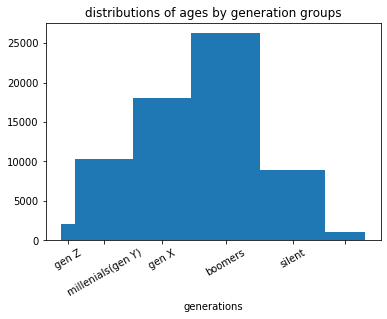

In [9]:
# distribution of age according to the definition of generations
# in 2018 the age edge as bins
age_min=target_dataset.age.min()  #18
age_max=target_dataset.age.max() #101
bins = [age_min, 22, 38, 54, 73, 91, age_max+1]
plt.hist(data=target_dataset, x='age' ,bins=bins);

plt.title('distributions of ages by generation groups')
plt.xlabel('generations')

ticks_loc = [20, 30, 46, 63.5, 82, 96.5]
ticks_label = ['gen Z', 'millenials(gen Y)', 'gen X', 'boomers', 'silent']
plt.xticks(ticks_loc, ticks_label, rotation=30) #rotation=90

plt.show()

Meantime, we can use also other informations(gender, income, member_days etc.) together to divide customer groups.<br>
Since the groups of `gen Z`(18-21) and the elder than `silent` are small, and the age is closed to the generation group nearby, so we finally make the segement as follows:
- age
- gender

|Segment #| Age Group (edge included)<br> (Experiment in 2018) | Gender | 
|---| --- | --- | 
|1| Millenials(-21 & 22-37) | M | 
|2| Millenials(-21 & 22-37) | F | 
|3| Millenials(-21 & 22-37) | O | 
|4| Gen X(38-53) | M|
|5| Gen X(38-53) | F|
|6| Gen X(38-53) | O|
|7| Baby Boomer(54-72) | M|
|8| Baby Boomer(54-72) | F|
|9| Baby Boomer(54-72) | O|
|10| Silent(73-90 & 91+) | M|
|11| Silent(73-90 & 91+) | F|
|12| Silent(73-90 & 91+) | O|

In [10]:
def segment_person(target_dataset):
    '''Make a segment to target_dataset.
    
    INPUT:
        - target_dataset(DataFrame)
    OUTPUT:
        - df_segments(list of DataFrame)
    '''
    df_segments=[]
    is_gender_M = (target_dataset.gender == 'M')
    is_gender_F = (target_dataset.gender == 'F')
    is_gender_O = (target_dataset.gender == 'O')
    
    age_min=target_dataset.age.min()  #18
    age_max=target_dataset.age.max() #101
    bins_begin = [age_min, 38, 54, 73]
    bins_end  = [38, 54, 73, age_max+1]
    for ages_begin, ages_end in zip(bins_begin, bins_end):
        is_generation = (target_dataset.age >= ages_begin) & (target_dataset.age < ages_end)
        df_segments.append(target_dataset[is_generation][is_gender_M])
        df_segments.append(target_dataset[is_generation][is_gender_F])
        df_segments.append(target_dataset[is_generation][is_gender_O])
    
    return df_segments 

df_segments = segment_person(target_dataset)

D:\JustPractice\1_MS_Geek_salute\PythonAnaconda\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
D:\JustPractice\1_MS_Geek_salute\PythonAnaconda\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
D:\JustPractice\1_MS_Geek_salute\PythonAnaconda\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [11]:
count_segments = []
for idx in range(0, 12):
    count_segments.append(df_segments[idx].shape[0])

In [12]:
print("the number of all records in df_segments is {}" .format(sum(count_segments)))
print("the number of records in the original target_dataset is {}" .format(target_dataset.shape[0]))
count_segments

the number of all records in df_segments is 66506
the number of records in the original target_dataset is 66506


[8603, 3659, 127, 10718, 6986, 290, 14192, 11698, 357, 4617, 5117, 142]

[Text(0, 0, 'Millenials'),
 Text(0, 0, 'Gen X'),
 Text(0, 0, 'Boomer'),
 Text(0, 0, 'Silent')]

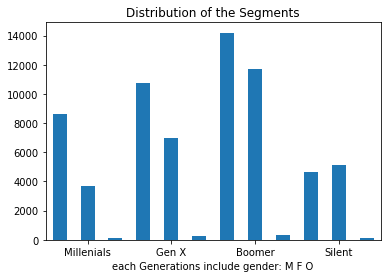

In [13]:
ax = (pd.Series(count_segments)).plot(kind="bar", rot=0);
xticks_loc = range(1, 11, 3)
xticks_label = ['Millenials', 'Gen X', 'Boomer', 'Silent']

ax.set_title('Distribution of the Segments')
ax.set_xlabel('each Generations include gender: M F O')
ax.set_xticks(xticks_loc)
ax.set_xticklabels(xticks_label)

- Get the DataFrames of segment `df_segments[0...11]`
- FOUND
    - the distribution of gender is huge unbalanced because of less number of gender 'O'. For heuristic analyzation is not a big problem.

## <a class="anchor" id="3">[III. Classes of responsiveness to the offers](#0)</a>
The all possible responsiveness defined as follows:<br>

|Group| received | viewed |valid completed | transaction amount |Scenario |
| :-| :-: | :-:| :-: | :-: | :- |
|1.none_offer| 0 | 0 | 0 | |haven't received the offer |
|2.no_care | 1 | 0 | - | |received but not viewed.<br> regarded as no_care|
|| 1 | 1 | 0 | =0.0 | received, viewed but no transaction |
|| 1 | 1 | 1<br>viewed after completed |  | received, but completed unintentionally |
|3.tried| 1 | 1 | 0 | >0.0|received, viewed, have transaction |
|4.effctive_offer | 1 | 1 | 1<br>viewed before completed | | viewed before completed,  effctive offer|

**NOTE：**
1. **'valid completed'**, means complete within the duration of the offer<br>
2. States like 0,0,1 or 0,1,0 or 0,1,1 are impossible in reality.
3. `label_effective_offer == '1'` means received and valid completed<br>
(More details at the begining of explanation for the datasets)

**Response GROUPs:**
1. `none_offer`(passive)<br>
    - I. not received, not viewed
        - `label_effective_offer`.isin([-1, -2]) & `time_viewed` == NaN 
2. `no_care`(active)<br>
    - I. received, but not viewed
        - `label_effective_offer`.isin([0, 1]) & `time_viewed` == NaN
    - II. received, viewed, but no transaction
        - `label_effective_offer` == 0 & `amount` == 0.0 & `time_viewed`.notnull() 
    - or III. received, viewed, completed but viewed time after completed time
        - `label_effective_offer` == 1 & `time_viewed` > `time_completed` #when time_viewed is NaN, always False
3. `tried`<br>
    - I. received, viewed, have transaction but not valid completed
        - `label_effective_offer` == 0 & `amount` > 0.0  & `time_viewed`.notnull() 
4. `effctive_offer`<br>
    - I. received, viewed, and completed, besides viewed time before completed time
        - `label_effective_offer` == 1 & `time_viewed` < `time_completed` #when time_viewed is NaN, always False

### <a class="anchor" id="3.1">[1. Divide the response into 4 groups](#Start)</a>

In [14]:
def group_none_offer(list_dfs):
    '''Group 1. person haven't received any offer.
    '''
    grouped_segment = []
    for df_segment in list_dfs:
        is_group = (df_segment.label_effective_offer.isin([-1, -2])) & (df_segment.time_viewed.isna())     #.isnull() .isna(); np.nan()
        grouped_segment.append(df_segment[is_group])
    
    return grouped_segment

In [15]:
def group_no_care(list_dfs):
    '''Group 2. person don't care about the offer.
    '''
    grouped_segment = []
    for df_segment in list_dfs:
        is_group_no_view = (df_segment.label_effective_offer.isin([0, 1])) & (df_segment.time_viewed.isna())
        is_group_no_trans = (df_segment.label_effective_offer == 0) & (df_segment.amount_with_offer == 0)  & (df_segment.time_viewed.notnull())#0和0.0没有区别
        is_group_later_view = (df_segment.label_effective_offer == 1) & (df_segment.time_viewed > df_segment.time_completed) 
        
        is_group = is_group_no_view | is_group_no_trans | is_group_later_view 
        grouped_segment.append(df_segment[is_group])
    
    return grouped_segment

In [16]:
def group_tried(list_dfs):
    '''Group 3. person tried.
    '''
    grouped_segment = []
    for df_segment in list_dfs:
        is_group = (df_segment.label_effective_offer == 0) & (df_segment.amount_with_offer > 0) & (df_segment.time_viewed.notnull())
        grouped_segment.append(df_segment[is_group])
    
    return grouped_segment

In [17]:
def group_effctive_offer(list_dfs):
    '''Group 4. effctive_offer.
    '''
    grouped_segment = []
    for df_segment in list_dfs:
        is_group = (df_segment.label_effective_offer == 1) & (df_segment.time_viewed <= df_segment.time_completed) 
        grouped_segment.append(df_segment[is_group])
    
    return grouped_segment

In [18]:
# list of segment DataFrame in none_offer group
# you can check:all time_viewed are NaNs
none_offer_segments = group_none_offer(df_segments)

# list of segment DataFrame in no_care group
# you can check: some time_viewed is after time_completed
no_care_segments = group_no_care(df_segments)

# list of segment DataFrame in tried group
tried_segments = group_tried(df_segments)

# list of segment DataFrame in no_care group
effctive_offer_segments = group_effctive_offer(df_segments)

### <a class="anchor" id="3.2">[2. CHECK the dividing method for the 4 groups of response to offer](#Start)</a>

In [19]:
# CHECK the 12 segments: the number of records are same XXXX
segment_records =[]
for df in df_segments:
    segment_records.append(df.shape[0])

print(sum(segment_records))
segment_records  #segments data

66506


[8603, 3659, 127, 10718, 6986, 290, 14192, 11698, 357, 4617, 5117, 142]

In [20]:
# CHECK the method of dividing the 4 groups of response:
# each segment(DataFrame) should have the same number of records
group_records = []
for idx in range(0,12):
    size = none_offer_segments[idx].shape[0] + no_care_segments[idx].shape[0]+tried_segments[idx].shape[0]+effctive_offer_segments[idx].shape[0]
    group_records.append(size)

print(sum(group_records))
group_records

66506


[8603, 3659, 127, 10718, 6986, 290, 14192, 11698, 357, 4617, 5117, 142]

- Conclusion from the result: <br>
the dividing method is correct.

### <a class="anchor" id="3.3">[3. Heuristic exploration in 4 aspects](#Start)</a>

In [21]:
# 1.divided to 4 response gourps
# 2.lebel for segment and group
def recons_target_group(group_one_lst, group_two_lst, label_col, name_group_one='group_one', name_group_two='group_two'):
    '''
    DESCRIPTION:
        Reconstruct the target group based on the 4 groups of segments: 
            none_offer_segments, no_care_segments, tried_segments and effctive_offer_segments
    
    INPUT:
        - group_one_lst(list of DataFrames)
        - label_col(str): new column name for label
        
        - group_one(str): name of group one
    '''

    group_one = [None] * 12
    group_two = [None] * 12
    group_labeled = [None] * 12
    
    # 12 segments
    for idx in range(0, 12):
        # for group one 
        concat_groups_one = [group[idx] for group in group_one_lst]
        group_one[idx] = pd.concat(concat_groups_one, axis=0)
        group_one[idx][label_col]= name_group_one
        
        # for group two
        concat_groups_two = [group[idx] for group in group_two_lst]
        group_two[idx] = pd.concat(concat_groups_two, axis=0)
        group_two[idx][label_col]= name_group_two
    
        group_labeled[idx] = pd.concat([group_one[idx], group_two[idx]], axis=0)
        group_labeled[idx]['label_seg'] = idx + 1  #segment #1-#12
    
    return group_labeled

### <a class="anchor" id="3.3.1">[`3.1` Offer Distributions: none_offer VS. others](#Start)</a>
1. Group one
    - none_offer_segments
2. Group two
    - no_care_segments
    - tried_segments
    - effctive_offer_segments

In [54]:
group_one_lst = [none_offer_segments]
group_two_lst = [no_care_segments, tried_segments, effctive_offer_segments]
label_col = 'Offer_Distributions'
name_group_one='none_offer'
name_group_two='with_offer'

group_labeled = recons_target_group(group_one_lst, group_two_lst, label_col, name_group_one, name_group_two)


# !!!CHECK
len_lst = []
for idx in range(0, 12):
    len_lst.append(group_labeled[idx].shape[0])
print(sum(len_lst))
len_lst

66506


[8603, 3659, 127, 10718, 6986, 290, 14192, 11698, 357, 4617, 5117, 142]

In [55]:
# combine all segments to one DataFrame

# 12 segments
# initial with the 1st segment
summary_dataset = group_labeled[0]
# append another 11 segments
for idx in range(1, 12):
    summary_dataset = summary_dataset.append(group_labeled[idx])

summary_dataset

,person,offer_id,time_received,time_viewed,time_transaction,time_completed,amount_with_offer,label_effective_offer,reward,difficulty,...,email,mobile,social,web,gender,age,income,member_days,Offer_Distributions,label_seg
59,32,0,0.0,4.00,NaN,NaN,0.00,0,10.0,10.0,...,1.0,1.0,1.0,0.0,M,22,70000.0,463,with_offer,1
120,299,4,21.0,NaN,",26.5",NaN,17.20,0,5.0,20.0,...,1.0,0.0,0.0,1.0,M,37,92000.0,596,with_offer,1
144,9885,4,7.0,NaN,",7.75,8.0,8.75,12.5,16.25",NaN,9.67,0,5.0,20.0,...,1.0,0.0,0.0,1.0,M,27,44000.0,432,with_offer,1
145,9885,3,14.0,NaN,",16.25,19.5,20.5",NaN,7.87,0,5.0,5.0,...,1.0,1.0,0.0,1.0,M,27,44000.0,432,with_offer,1
147,9885,6,24.0,25.25,",24.5,24.75",24.75,1.84,1,2.0,10.0,...,1.0,1.0,1.0,1.0,M,27,44000.0,432,with_offer,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62514,8039,5,14.0,14.00,",14.5",14.50,47.63,1,3.0,7.0,...,1.0,1.0,1.0,1.0,O,92,97000.0,1219,with_offer,12
62515,8039,3,24.0,24.00,",24.0",24.00,24.07,1,5.0,5.0,...,1.0,1.0,0.0,1.0,O,92,97000.0,1219,with_offer,12
65389,13484,3,17.0,17.00,",17.0",17.00,22.49,1,5.0,5.0,...,1.0,1.0,0.0,1.0,O,77,92000.0,379,with_offer,12
65390,13484,5,21.0,21.25,",21.5",21.50,22.12,1,3.0,7.0,...,1.0,1.0,1.0,1.0,O,77,92000.0,379,with_offer,12


### [3.1.i Visualization](#Start)

In [24]:
# Encode dict for segments
seg_encode = {1: 'Millenials(-21&22-37) M',
              2: 'Millenials(-21&22-37) F',
              3: 'Millenials(-21&22-37) O',
              4: 'Gen X(38-53) M',
              5: 'Gen X(38-53) F',
              6: 'Gen X(38-53) 0',
              7: 'Baby Boomer(54-72) M',
              8: 'Baby Boomer(54-72) F',
              9: 'Baby Boomer(54-72) O',
              10: 'Silent(73-90 & 91+) M',
              11: 'Silent(73-90 & 91+) F',
              12: 'Silent(73-90 & 91+) O'}

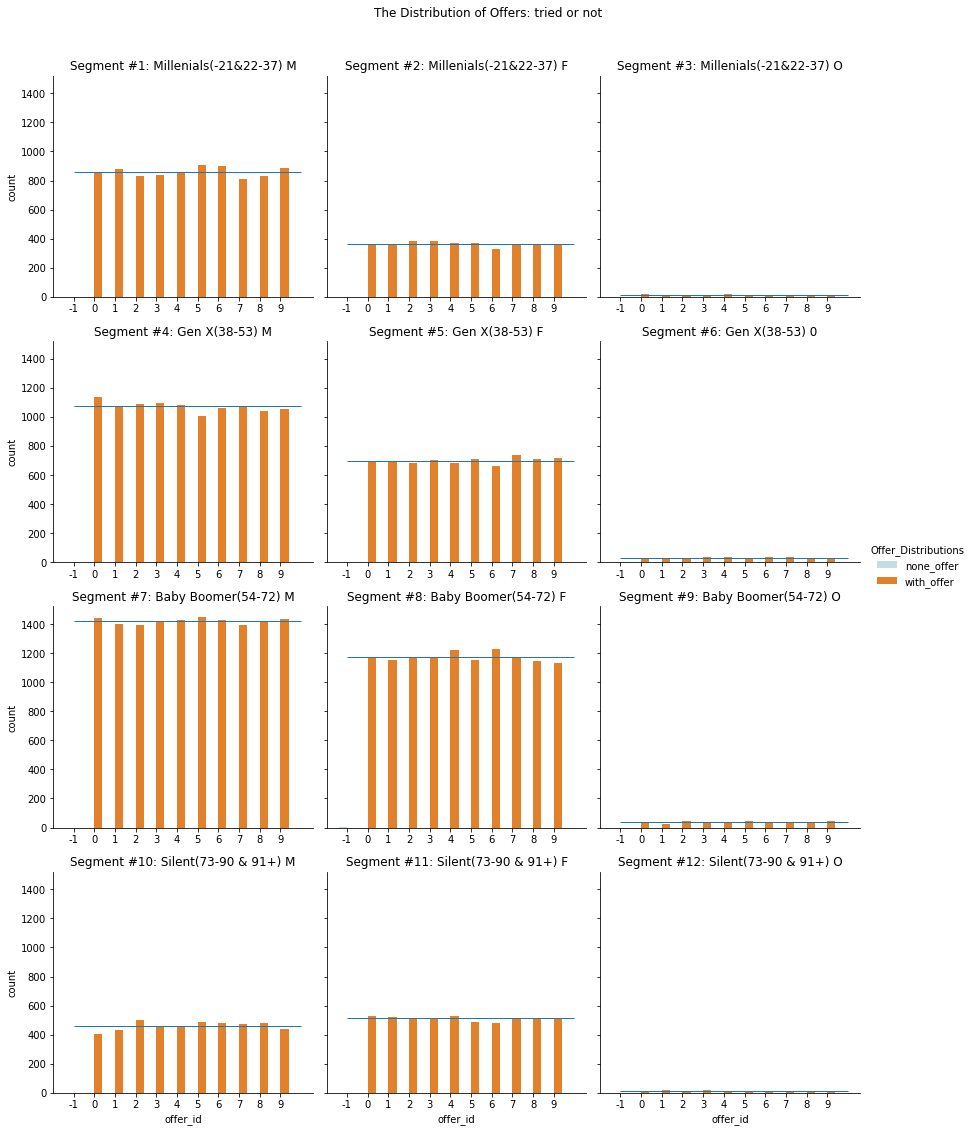

In [56]:
color_cold = sb.color_palette("RdBu", n_colors=7)[4]
color_warm = sb.color_palette()[1]
color_hline = sb.color_palette()[0]


g = sb.catplot(x="offer_id", hue="Offer_Distributions",  col="label_seg", col_wrap=3, 
               hue_order=[name_group_one, name_group_two],
               data=summary_dataset, kind="count",height=4, aspect=1, 
               palette=[color_cold, color_warm], legend=True);

#g.add_legend(legend_data= {'none offer': g._legend_data['group one'], 'with offer': g._legend_data['group two']})  #delete original dict values
# handles = g._legend_data.values()
# plt.legend(handles, labels=[name_group_one, name_group_two], loc=2)  #指针对最后一个图
#g.set_titles("Segment #{col_name}")  #{col_var} is label_seg

# set a title 
plt.subplots_adjust(top=0.92, hspace=0.2);
g.fig.suptitle('The Distribution of Offers: tried or not')

# a horizontal line for mean values just for the group two: "with offer"
# group "with offer"
is_with_offer = (summary_dataset.Offer_Distributions == 'with_offer')
dataset_with_offer = summary_dataset[is_with_offer]
# calculate mean values
mean_values = [None]*12
for i in range(0,12):
    is_segment = (dataset_with_offer.label_seg == i+1)
    dataset_with_offer_seg = dataset_with_offer[is_segment]
    # 10 offers
    mean_value = dataset_with_offer_seg.offer_id.count() / 10
    mean_values[i] = mean_value


for idx, ax in enumerate(g.axes.flatten()):
    ax.tick_params(labelbottom=True)
    ax.set_title('Segment #{}: {}' .format(idx+1, seg_encode[idx+1]))
    ax.hlines(mean_values[idx], 0, 11, color=color_hline, linewidth=1)
    #ax.legend()

In [57]:
# the whole group of offer not received
is_none_offer = (summary_dataset.offer_id == '-1')
summary_dataset[is_none_offer]

,person,offer_id,time_received,time_viewed,time_transaction,time_completed,amount_with_offer,label_effective_offer,reward,difficulty,...,email,mobile,social,web,gender,age,income,member_days,Offer_Distributions,label_seg
66501,5639,-1,NaN,NaN,-1,NaN,0.0,-2,NaN,NaN,...,NaN,NaN,NaN,NaN,F,66,34000.0,459,none_offer,8
66503,872,-1,NaN,NaN,-1,NaN,0.0,-2,NaN,NaN,...,NaN,NaN,NaN,NaN,F,72,35000.0,444,none_offer,8
66504,14763,-1,NaN,NaN,-1,NaN,0.0,-2,NaN,NaN,...,NaN,NaN,NaN,NaN,F,54,72000.0,725,none_offer,8
66505,6789,-1,NaN,NaN,-1,NaN,0.0,-2,NaN,NaN,...,NaN,NaN,NaN,NaN,F,55,88000.0,868,none_offer,8
66502,15391,-1,NaN,NaN,-1,NaN,0.0,-2,NaN,NaN,...,NaN,NaN,NaN,NaN,M,91,70000.0,1184,none_offer,10


### [3.1.ii Conclusion](#Start)
**Notice:**
1. `offer_id == -1` means person haven't received any offer

**FOUND:**
1. There are just 5 person, who never received the offer
    - 4 person in segment \#8
    - 1 person in segment \#10
2. The distribution of gender 
    - Segment in the third column is `gender=='O'`, this group is small compared with Male and Female.
    - In segment #(1, 2, 4, 5, 7, 8), the distribution is not balanced according to the horizontal line of mean value.
<br> In all segments of different generation, the distribution of gender(Male, Female) 
3. These 5 person(`offer_id=='-1'`) are the whole `label_effective_offer == -2` group

### <a class="anchor" id="3.3.2">[`3.2` Interest Distributions: no_care VS. (tried & effective_offer)](#Start)</a>
1. Group one
    - no_care_segments
2. Group two
    - tried_segments
    - effctive_offer_segments

In [58]:
group_one_lst = [no_care_segments]
group_two_lst = [tried_segments, effctive_offer_segments]
label_col = 'Interest_Distributions'
name_group_one='no_care'
name_group_two='tried or effctive'

group_labeled = recons_target_group(group_one_lst, group_two_lst, label_col, name_group_one, name_group_two)


# combine all segments to one DataFrame
# 12 segments
# initial with the 1st segment
summary_dataset = group_labeled[0]
# append another 11 segments
for idx in range(1, 12):
    summary_dataset = summary_dataset.append(group_labeled[idx])
summary_dataset  
# 5 person with none_offer reduced 

,person,offer_id,time_received,time_viewed,time_transaction,time_completed,amount_with_offer,label_effective_offer,reward,difficulty,...,email,mobile,social,web,gender,age,income,member_days,Interest_Distributions,label_seg
59,32,0,0.0,4.00,NaN,NaN,0.00,0,10.0,10.0,...,1.0,1.0,1.0,0.0,M,22,70000.0,463,no_care,1
120,299,4,21.0,NaN,",26.5",NaN,17.20,0,5.0,20.0,...,1.0,0.0,0.0,1.0,M,37,92000.0,596,no_care,1
144,9885,4,7.0,NaN,",7.75,8.0,8.75,12.5,16.25",NaN,9.67,0,5.0,20.0,...,1.0,0.0,0.0,1.0,M,27,44000.0,432,no_care,1
145,9885,3,14.0,NaN,",16.25,19.5,20.5",NaN,7.87,0,5.0,5.0,...,1.0,1.0,0.0,1.0,M,27,44000.0,432,no_care,1
147,9885,6,24.0,25.25,",24.5,24.75",24.75,1.84,1,2.0,10.0,...,1.0,1.0,1.0,1.0,M,27,44000.0,432,no_care,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62514,8039,5,14.0,14.00,",14.5",14.50,47.63,1,3.0,7.0,...,1.0,1.0,1.0,1.0,O,92,97000.0,1219,tried or effctive,12
62515,8039,3,24.0,24.00,",24.0",24.00,24.07,1,5.0,5.0,...,1.0,1.0,0.0,1.0,O,92,97000.0,1219,tried or effctive,12
65389,13484,3,17.0,17.00,",17.0",17.00,22.49,1,5.0,5.0,...,1.0,1.0,0.0,1.0,O,77,92000.0,379,tried or effctive,12
65390,13484,5,21.0,21.25,",21.5",21.50,22.12,1,3.0,7.0,...,1.0,1.0,1.0,1.0,O,77,92000.0,379,tried or effctive,12


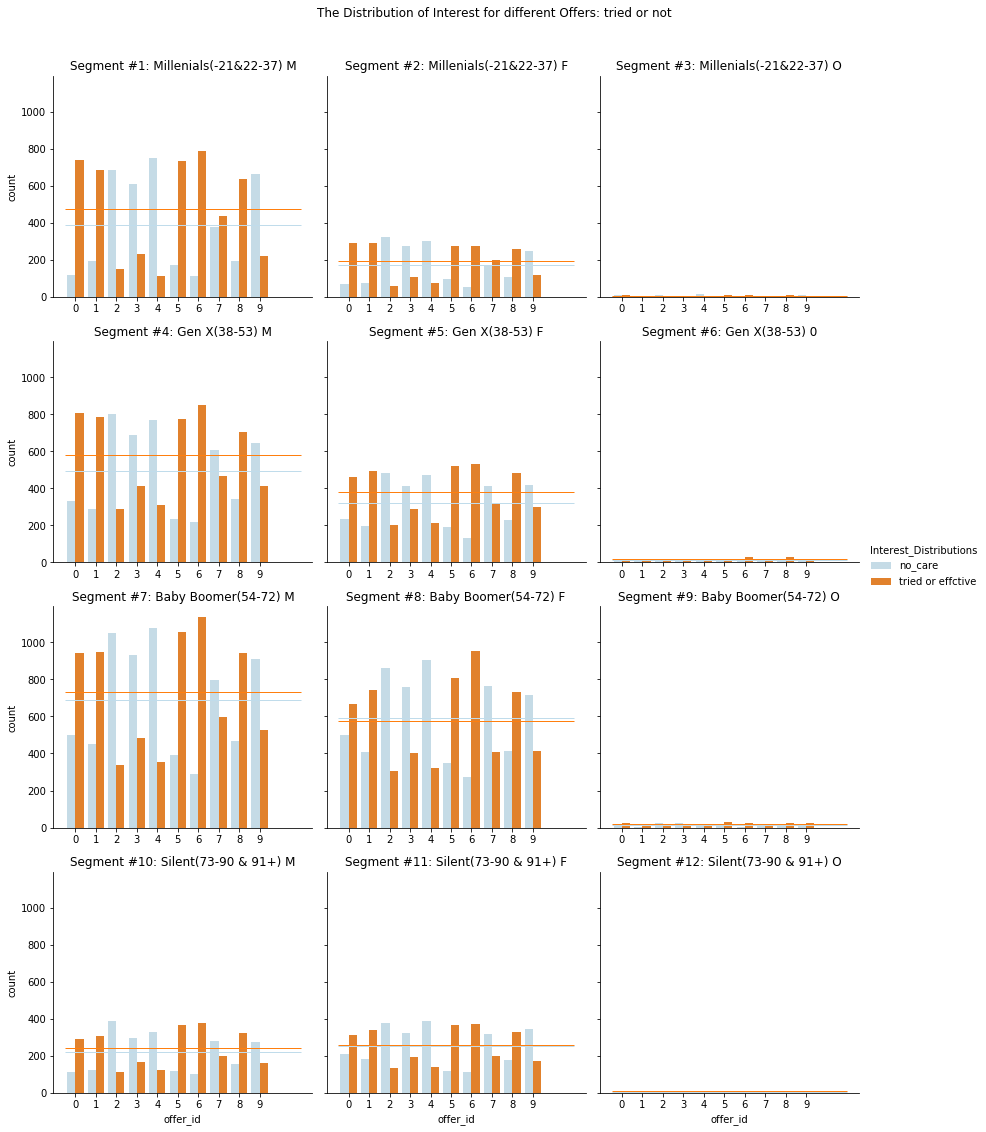

In [63]:
color_cold = sb.color_palette("RdBu", n_colors=7)[4]
color_warm = sb.color_palette()[1]
color_hline = sb.color_palette()[0]


g = sb.catplot(x="offer_id", hue="Interest_Distributions",  col="label_seg", col_wrap=3, 
               hue_order=[name_group_one, name_group_two],
               data=summary_dataset, kind="count",height=4, aspect=1, 
               palette=[color_cold, color_warm], legend=True);

# set a title 
plt.subplots_adjust(top=0.92, hspace=0.2);
g.fig.suptitle('The Distribution of Interest for different Offers: tried or not')


# horizontal lines for mean values for two group
# 1st group "no_care"
is_no_care = (summary_dataset.Interest_Distributions == 'no_care') #
dataset_no_care = summary_dataset[is_no_care]


# 2nd group "tried or effctive"
is_tried_effctive = (summary_dataset.Interest_Distributions == 'tried or effctive') #
dataset_tried_effctive = summary_dataset[is_tried_effctive]


# calculate mean values
mean_values_one = [None]*12
mean_values_two = [None]*12

for i in range(0,12):
    is_segment_one = (dataset_no_care.label_seg == i+1)
    dataset_no_care_seg = dataset_no_care[is_segment_one]
    # 10 offers
    mean_value_one = dataset_no_care_seg.offer_id.count() / 10
    mean_values_one[i] = mean_value_one
    
    is_segment_two = (dataset_tried_effctive.label_seg == i+1)
    dataset_tried_effctive_seg = dataset_tried_effctive[is_segment_two]
    mean_value_two = dataset_tried_effctive_seg.offer_id.count() / 10
    mean_values_two[i] = mean_value_two

    

for idx, ax in enumerate(g.axes.flatten()):
    ax.tick_params(labelbottom=True)
    ax.set_title('Segment #{}: {}' .format(idx+1, seg_encode[idx+1]))
    ax.hlines(mean_values_one[idx], -0.5, 11, color=color_cold, linewidth=1)
    ax.hlines(mean_values_two[idx], -0.5, 11, color=color_warm, linewidth=1)
    #ax.legend()

### the details of offer_id(10 kinds)
| offer_id #| type | duration | requirement | reward |
|:-| :-| :-:|:-:|:-:|
| 0 | bogo | 7 | 10 | 10 |
| 1 | bogo | 5 | 10 | 10 |
| 2 | infomational | 4 | - | - |
| 3 | bogo | 7 | 5 | 5 |
| 4 | discount | 10 | 20 | 5 |
| 5 | discount | 7 | 7 | 3 |
| 6 | discount | 10 | 10 | 2 |
| 7 | informational | 3 | - | - |
| 8 | bogo | 5 | 5 | 5 |
| 9 | discount | 7 | 10 | 2 |

### <a class="anchor" id="3.3.3">[`3.3` Difficulty Distributions: tried VS. effective_offer](#Start)</a>
1. Group one
    - tried_segments
2. Group two
    - effctive_offer_segments 

In [65]:
group_one_lst = [tried_segments]
group_two_lst = [effctive_offer_segments]
label_col = 'Difficulty_Distributions'
name_group_one='tried but failed'
name_group_two='effctive'

group_labeled = recons_target_group(group_one_lst, group_two_lst, label_col, name_group_one, name_group_two)


# combine all segments to one DataFrame
# 12 segments
# initial with the 1st segment
summary_dataset = group_labeled[0]
# append another 11 segments
for idx in range(1, 12):
    summary_dataset = summary_dataset.append(group_labeled[idx])
summary_dataset #(34888, 22)

,person,offer_id,time_received,time_viewed,time_transaction,time_completed,amount_with_offer,label_effective_offer,reward,difficulty,...,email,mobile,social,web,gender,age,income,member_days,Difficulty_Distributions,label_seg
143,9885,1,0.0,2.00,",2.0,3.25",NaN,4.28,0,10.0,10.0,...,1.0,1.0,1.0,1.0,M,27,44000.0,432,tried but failed,1
146,9885,6,21.0,22.00,",22.75,23.25,23.5,24.5,24.75,25.5,28.0,29.5",NaN,23.99,0,2.0,10.0,...,1.0,1.0,1.0,1.0,M,27,44000.0,432,tried but failed,1
197,82,8,24.0,24.25,",25.0,26.5,27.75,28.0,29.0",NaN,8.48,0,5.0,5.0,...,1.0,1.0,1.0,1.0,M,27,35000.0,356,tried but failed,1
364,127,0,14.0,14.25,",14.25",NaN,9.02,0,10.0,10.0,...,1.0,1.0,1.0,0.0,M,26,71000.0,386,tried but failed,1
395,776,1,21.0,21.00,",21.25,21.75,22.5,23.5,24.5,24.75,25.5",NaN,31.05,0,10.0,10.0,...,1.0,1.0,1.0,1.0,M,25,68000.0,1162,tried but failed,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62514,8039,5,14.0,14.00,",14.5",14.5,47.63,1,3.0,7.0,...,1.0,1.0,1.0,1.0,O,92,97000.0,1219,effctive,12
62515,8039,3,24.0,24.00,",24.0",24.0,24.07,1,5.0,5.0,...,1.0,1.0,0.0,1.0,O,92,97000.0,1219,effctive,12
65389,13484,3,17.0,17.00,",17.0",17.0,22.49,1,5.0,5.0,...,1.0,1.0,0.0,1.0,O,77,92000.0,379,effctive,12
65390,13484,5,21.0,21.25,",21.5",21.5,22.12,1,3.0,7.0,...,1.0,1.0,1.0,1.0,O,77,92000.0,379,effctive,12


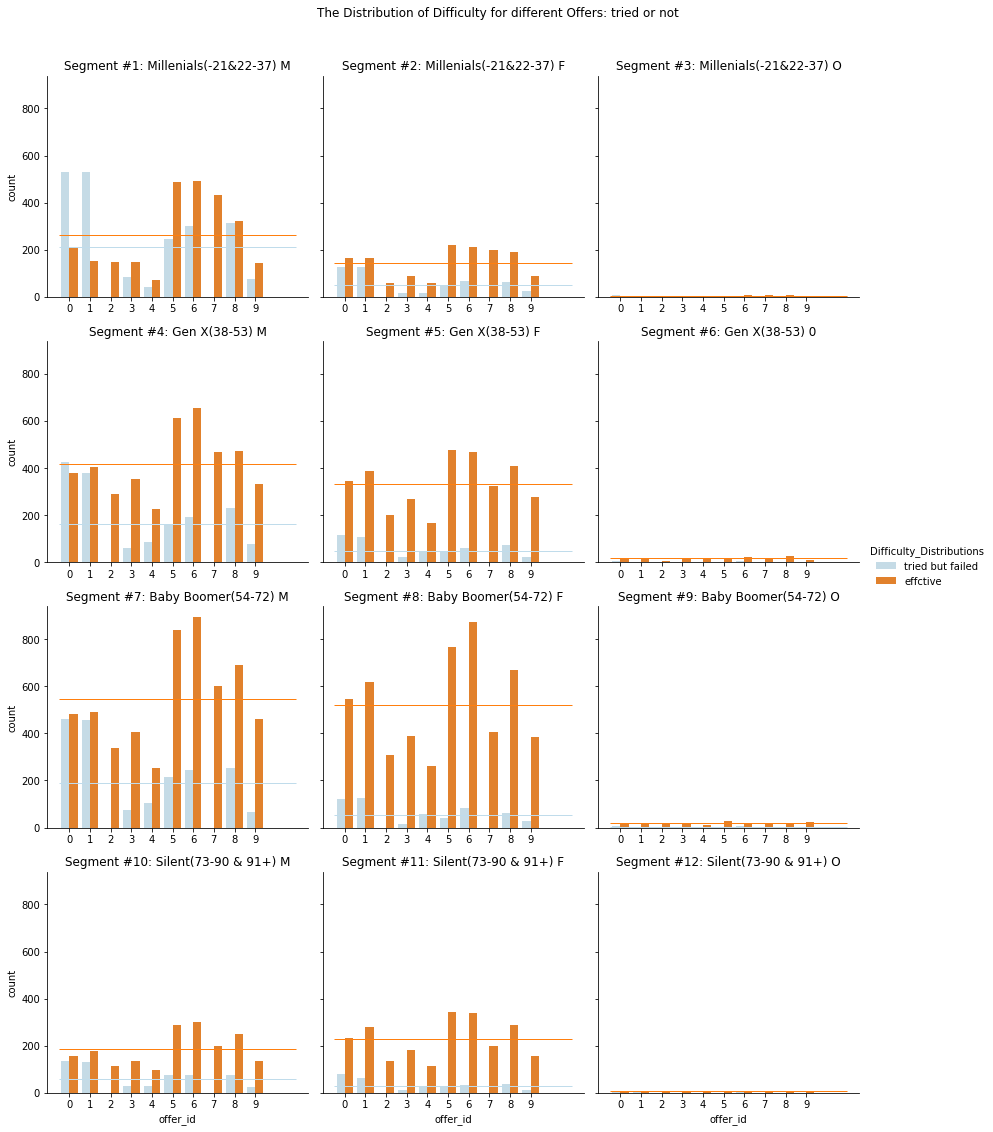

In [68]:
color_cold = sb.color_palette("RdBu", n_colors=7)[4]
color_warm = sb.color_palette()[1]
color_hline = sb.color_palette()[0]


g = sb.catplot(x="offer_id", hue="Difficulty_Distributions",  col="label_seg", col_wrap=3, 
               hue_order=[name_group_one, name_group_two],
               data=summary_dataset, kind="count",height=4, aspect=1, 
               palette=[color_cold, color_warm], legend=True);

# set a title 
plt.subplots_adjust(top=0.92, hspace=0.2);
g.fig.suptitle('The Distribution of Difficulty for different Offers: tried or not')


# horizontal lines for mean values for two group
# 1st group "tried"
is_tried = (summary_dataset.Difficulty_Distributions == 'tried but failed') #
dataset_tried = summary_dataset[is_tried]


# 2nd group "effctive"
is_effctive = (summary_dataset.Difficulty_Distributions == 'effctive') #
dataset_effctive = summary_dataset[is_effctive]


# calculate mean values
mean_values_one = [None]*12
mean_values_two = [None]*12

for i in range(0,12):
    is_segment_one = (dataset_tried.label_seg == i+1)
    dataset_tried_seg = dataset_tried[is_segment_one]
    # 10 offers
    mean_value_one = dataset_tried_seg.offer_id.count() / 10
    mean_values_one[i] = mean_value_one
    
    is_segment_two = (dataset_effctive.label_seg == i+1)
    dataset_effctive_seg = dataset_effctive[is_segment_two]
    mean_value_two = dataset_effctive_seg.offer_id.count() / 10
    mean_values_two[i] = mean_value_two

    

for idx, ax in enumerate(g.axes.flatten()):
    ax.tick_params(labelbottom=True)
    ax.set_title('Segment #{}: {}' .format(idx+1, seg_encode[idx+1]))
    
    # add horizontal lines
    ax.hlines(mean_values_one[idx], -0.5, 11, color=color_cold, linewidth=1)
    ax.hlines(mean_values_two[idx], -0.5, 11, color=color_warm, linewidth=1)
    #ax.legend()

### <a class="anchor" id="3.3.4">[`3.4` Index IIR: Is the offer significant popular?](#Start)</a>
Definition of IIR: Incremental Response Rate
$$IIR= \frac{n_1}{sum_1}-\frac{n_0}{sum_0} $$ <br>

| Symbol | Meaning |
| :- | :- |
| $$n_1$$ | number of Purchasers in Treated Group |
| $$sum_1$$ | Total number of Purchasers in Treated Group |
| $$n_0$$ | number of Purchasers in Control Group |
| $$sum_0$$ | Total number of Purchasers in Control Group |

1. Total number in Control Group: 
    - i. not viewed, no matter received or not
        - `time_viewed` == NaN # the special 5 person with label_effective_offer == -2
    - ii. viewed after completed
        - `label_effective_offer` == 1 & `time_viewed` > `time_completed`  
  
n0 is subset: `label_effective_offer` == 1 in control group

2. Total number in Treated Group:
    - i. viewed before completed, when there is 'completed'
        - `label_effective_offer` == 1 & `time_viewed` < `time_completed` 
    - ii. viewed, when there is 'no completed'
        - `label_effective_offer` == 0 & `time_viewed` >= 0.0  
        
n1 is subset: `label_effective_offer` == 1 in control group

In [82]:
def group_control(list_dfs, name_group, name_seg):
    '''
    '''
    grouped_segment = []
    for idx, df_segment in enumerate(list_dfs):
        is_none_view = (df_segment.time_viewed.isnull())
        is_viewed_after = (df_segment.label_effective_offer == 1) & (df_segment.time_viewed >= df_segment.time_completed)
        
        is_group = is_none_view | is_viewed_after
        df_append = df_segment[is_group]
        df_append[name_group] = 'control'
        df_append[name_seg] = idx + 1
        
        grouped_segment.append(df_append)
    
    return grouped_segment

In [83]:
def group_treated(list_dfs, name_group, name_seg):
    '''&labeled
    '''
    grouped_segment = []
    # 12 segment, each segment has 10 offer statistiks
    offer_stats = [None]*12 #list size: 12*10
    for idx, df_segment in enumerate(list_dfs):
        is_viewed_before = (df_segment.label_effective_offer == 1) & (df_segment.time_viewed < df_segment.time_completed) 
        is_viewed_fail = (df_segment.label_effective_offer == 0) & (df_segment.time_viewed >= 0.0)
        
        is_group = is_viewed_before | is_viewed_fail
        df_append = df_segment[is_group]
        df_append[name_group] = 'treated'
        df_append[name_seg] = idx + 1
        
        grouped_segment.append(df_append)
    
    return grouped_segment

In [84]:
name_group = 'label_group'
name_seg = 'label_seg'
# get 12 DataFrames list in control group with lables of both group and segment
control_segments = group_control(df_segments, name_group, name_seg)

# get 12 DataFrames list in treated group with lables of both group and segment
treated_segments = group_treated(df_segments, name_group, name_seg)

D:\JustPractice\1_MS_Geek_salute\PythonAnaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
D:\JustPractice\1_MS_Geek_salute\PythonAnaconda\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [88]:
# combine all segments to one DataFrame
# [12 Segments/Group] * 2 Groups

summary_dataset = pd.DataFrame()
for idx in range(0, 12):
    df_concat = pd.concat([control_segments[idx], treated_segments[idx]], axis=0)
    summary_dataset = summary_dataset.append(df_concat)
summary_dataset  #(66506, 22)

,person,offer_id,time_received,time_viewed,time_transaction,time_completed,amount_with_offer,label_effective_offer,reward,difficulty,...,email,mobile,social,web,gender,age,income,member_days,label_group,label_seg
62,32,5,17.0,17.25,",17.25",17.25,20.63,1,3.0,7.0,...,1.0,1.0,1.0,1.0,M,22,70000.0,463,control,1
119,299,0,0.0,0.00,",0.0",0.00,18.01,1,10.0,10.0,...,1.0,1.0,1.0,0.0,M,37,92000.0,596,control,1
120,299,4,21.0,NaN,",26.5",NaN,17.20,0,5.0,20.0,...,1.0,0.0,0.0,1.0,M,37,92000.0,596,control,1
144,9885,4,7.0,NaN,",7.75,8.0,8.75,12.5,16.25",NaN,9.67,0,5.0,20.0,...,1.0,0.0,0.0,1.0,M,27,44000.0,432,control,1
145,9885,3,14.0,NaN,",16.25,19.5,20.5",NaN,7.87,0,5.0,5.0,...,1.0,1.0,0.0,1.0,M,27,44000.0,432,control,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62514,8039,5,14.0,14.00,",14.5",14.50,47.63,1,3.0,7.0,...,1.0,1.0,1.0,1.0,O,92,97000.0,1219,treated,12
65390,13484,5,21.0,21.25,",21.5",21.50,22.12,1,3.0,7.0,...,1.0,1.0,1.0,1.0,O,77,92000.0,379,treated,12
66364,14575,1,14.0,14.00,NaN,NaN,0.00,0,10.0,10.0,...,1.0,1.0,1.0,1.0,O,81,57000.0,517,treated,12
66365,14575,1,24.0,24.00,",24.25,25.5",NaN,0.96,0,10.0,10.0,...,1.0,1.0,1.0,1.0,O,81,57000.0,517,treated,12


In [91]:
is_treated = (summary_dataset.label_group == 'treated')
sum_treated = summary_dataset[is_treated].groupby(['label_seg', 'offer_id']).count()#.sort_values(['label_seg','offer_id'],ascending=True)
sum_treated

person  time_received  time_viewed  time_transaction  \
label_seg offer_id                                                         
1         0            768            768          768               708   
          1            765            765          765               662   
          2            164            164          164               164   
          3            231            231          231               216   
          4            115            115          115               110   
...                    ...            ...          ...               ...   
12        5             11             11           11                 9   
          6             10             10           10                 8   
          7             12             12           12                12   
          8              7              7            7                 6   
          9              8              8            8                 6   

                    time_completed  amount_with_offer  label_effective_offer  \
label_seg offer_id                                                             
1         0                    176                768                    768   
          1                    133                765                    765   
          2                    119                164                    164   
          3                    133                231                    231   
          4                     70                115                    115   
...                            ...                ...                    ...   
12        5                      8                 11                     11   
          6                      6                 10                     10   
          7                      6                 12                     12   
          8                      5                  7                      7   
          9                      6                  8                      8   

                    reward  difficulty  duration  offer_type  email  mobile  \
label_seg offer_id                                                            
1         0            768         768       768         768    768     768   
          1            765         765       765         765    765     765   
          2            164         164       164         164    164     164   
          3            231         231       231         231    231     231   
          4            115         115       115         115    115     115   
...                    ...         ...       ...         ...    ...     ...   
12        5             11          11        11          11     11      11   
          6             10          10        10          10     10      10   
          7             12          12        12          12     12      12   
          8              7           7         7           7      7       7   
          9              8           8         8           8      8       8   

                    social  web  gender  age  income  member_days  label_group  
label_seg offer_id                                                              
1         0            768  768     768  768     768          768          768  
          1            765  765     765  765     765          765          765  
          2            164  164     164  164     164          164          164  
          3            231  231     231  231     231          231          231  
          4            115  115     115  115     115          115          115  
...                    ...  ...     ...  ...     ...          ...          ...  
12        5             11   11      11   11      11           11           11  
          6             10   10      10   10      10           10           10  
          7             12   12      12   12      12           12           12  
          8              7    7       7    7       7            7      

In [ ]:
qwer

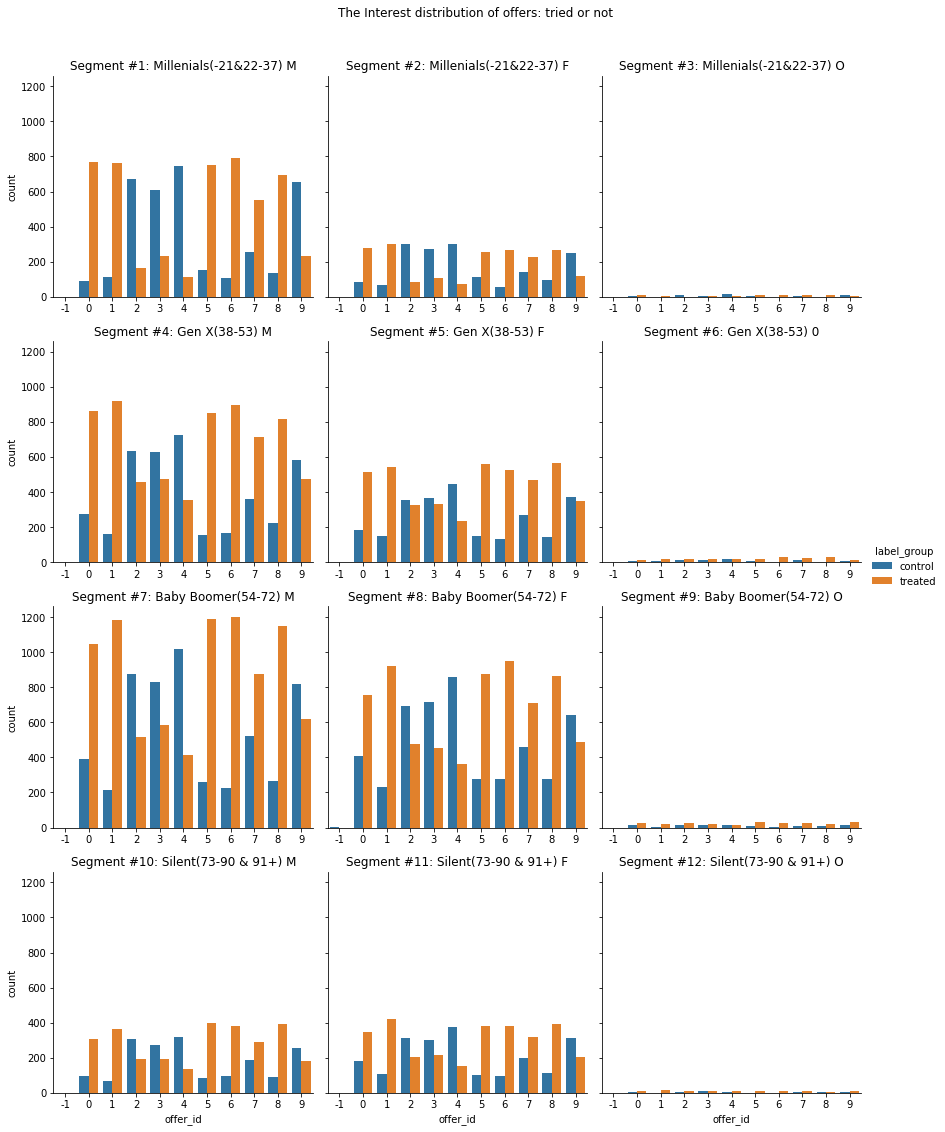

In [89]:
color_cold = sb.color_palette("RdBu", n_colors=7)[4]
color_warm = sb.color_palette()[1]
color_hline = sb.color_palette()[0]


g = sb.catplot(x="offer_id", hue="label_group",  col="label_seg", col_wrap=3, 
               hue_order=['control', 'treated'],
               data=summary_dataset, kind="count",height=4, aspect=1, 
               palette=[color_cold, color_warm], legend=True);

# set a title 
plt.subplots_adjust(top=0.92, hspace=0.2);
g.fig.suptitle('The Distribution of Difficulty for different Offers: tried or not')


# horizontal lines for mean values for two group
# 1st group "tried"
is_control = (summary_dataset.label_group == 'control') #
dataset_control = summary_dataset[is_tried]


# 2nd group "effctive"
is_effctive = (summary_dataset.Difficulty_Distributions == 'effctive') #
dataset_effctive = summary_dataset[is_effctive]


# calculate mean values
mean_values_one = [None]*12
mean_values_two = [None]*12

for i in range(0,12):
    is_segment_one = (dataset_tried.label_seg == i+1)
    dataset_tried_seg = dataset_tried[is_segment_one]
    # 10 offers
    mean_value_one = dataset_tried_seg.offer_id.count() / 10
    mean_values_one[i] = mean_value_one
    
    is_segment_two = (dataset_effctive.label_seg == i+1)
    dataset_effctive_seg = dataset_effctive[is_segment_two]
    mean_value_two = dataset_effctive_seg.offer_id.count() / 10
    mean_values_two[i] = mean_value_two

    

for idx, ax in enumerate(g.axes.flatten()):
    ax.tick_params(labelbottom=True)
    ax.set_title('Segment #{}: {}' .format(idx+1, seg_encode[idx+1]))
    
    # add horizontal lines
    ax.hlines(mean_values_one[idx], -0.5, 11, color=color_cold, linewidth=1)
    ax.hlines(mean_values_two[idx], -0.5, 11, color=color_warm, linewidth=1)
    #ax.legend()

## <a class="anchor" id="References">[References](#0)</a>
[[1]Starbucks Capstone Challenge: Using Starbucks app user data to predict effective offers](https://github.com/syuenloh/UdacityDataScientistCapstone/blob/master/Starbucks%20Capstone%20Challenge%20-%20Using%20Starbucks%20app%20user%20data%20to%20predict%20effective%20offers.ipynb)<br>
[[2]Starbucks Promotion Optimization](https://towardsdatascience.com/starbucks-promotion-optimization-ca56e29fb584)<br>
[[3]generations-and-age](https://www.pewresearch.org/topics/generations-and-age/)<br>
[[4]single taxable income](https://en.wikipedia.org/wiki/Income_tax_in_the_United_States#Marginal_tax_rates_for_2019)

# 补充
```python
#no need after BUG fixed
# update time_completed for informational effctive offers
# for informational offer, time_transaction(only one) is time_completed
is_change_time_complete = (target_dataset.offer_id.isin(['2','7'])) & (target_dataset.label_effective_offer == 1)
target_dataset.loc[is_change_time_complete, 'time_completed'] = target_dataset[is_change_time_complete]['time_transaction'].apply(lambda x: float(x))
```
1. 更新target_dataset中informational offer的time_complete
2. 替换column中subset的值
    - instead using `.loc[row_indexer,col_indexer] = value`
3. element-wise logical-and. That is what the & binary operator performs
4. 含nan的判断都是Fasle
    - 1.3>=np.nan
    - 1.3<=np.nan
    - np.nan<=1.3
    - np.nan==np.nan
5. 再次检查数据处理的程序
    - 针对其他offer,completed标志保障了：there must be transaction(s) & amount >= difficulty

### 可视化
1. FacetGrid没有考虑整体情况，有的子图单个分类数据为0
——>选择catplot配合countplot
    - 修改legend

```python
#g.add_legend(legend_data= {'none offer': g._legend_data['group one'], 'with offer': g._legend_data['group two']})  #delete original dict values
# handles = g._legend_data.values()
# plt.legend(handles, labels=[name_group_one, name_group_two], loc=2)  #指针对最后一个图
```

In [ ]:
''' FacetGrid 第一个子图影响参数
g1 = sb.FacetGrid(summary_dataset, hue="offer_distributions", hue_order=['group one', 'group two'], col='label_seg', col_wrap=3)
g1 = g1.map_dataframe(sb.countplot, 'offer_id')
'''

According to [References[4]](https://en.wikipedia.org/wiki/Income_tax_in_the_United_States#Marginal_tax_rates_for_2019), we get the `single taxable income` of Americans in 2018.
<img src='./images/tax.png'>

In [ ]:
min_income = target_dataset.income.min() #30,000
max_income = target_dataset.income.max() #120,000

bins = [min_income, 38701, 82501, max_income+1]
target_dataset.income.hist(bins=bins)